# Summary

__Airbnb/Kaggle Competition: Where will a new guest book their first travel experience?__


New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.
<br>
<br>
__Objective:__
<br>
_Predict in which country a new user will make his or her first booking._

# Process
- First I examined each data set and determined the variables that connected them.
- I then explored initial distributions and correlations
- __Sessions data__
    - A function isolated key words in the "action_detail" column in order to reduce variables and highlight key user behaviors
    - I then pivoted the data to calculate the median time spend on each action_key_word per user
- __Train_users & Test_users data__
    - I joined the sessions data with train_users and test_users to link user behavior with user profile information such as language, age, and gender.
    - I built functions to simplify the following categories:
        - Age (grouped into buckets - originally I scaled it as a continuos variable but it was hard to extract feature importance this way)
        - Device (Desktop, Tablet, Phone, etc)
        - Operating System (Mac, PC, Google, Other)
        - Gender (replaced "unknown" with "other")
- __Merged Data__
    - Once Sessions and User data were merged, I scaled continous variables and created dummies for all others.
    - I then began running models, which had less than ideal results (50-60% accuracy) but interesting feature importances.

# Findings
<br>
__Random Forest Top Feature Importances:__
<br>
- Browser type is more predictive than OS or device type; this likely reflects that browsers are more segmented by country, as well as the possibility that user experience is improved on a desktop computer. 
- Most Airbnb users are between the ages of 18-39. There is opportunity to expand older clientelle.
- It is interesting that action key words and med_seconds_elapsed were at the top of feature importances for the random trees model.
    - "Wishlists" are a promising way to predic where consumers may travel
    - Users who spend time messaging, updating their profiles, and searching content are naturally more engaged with the service. If these active users could be clustered, more information about their preferences and similaries may be determined. 
- Men are currently more likely to book listings that women. Could destination suggestions be tailored towards male audiences?
<br>
<img style="float: left;" src="http://imgur.com/h2NMfvv.png">
<br>

__Logistic Regression Feature Importances__
<br>
- Logistic Regression offered less interpretable feature importances, however a few key takeaways were apparent.
- Language heavily influences where poeple travel. This could have to do with cultural comforts or simply ease of use in the application.
    - Airbnb has a unique challenge in delivering its service. It is an international business that relies on the quality of communication of its users. This is demonstrated by the significance of language as well as the variance between cumulative view time and median view time. They traffic a high volume of views but appear to have low conversion. Is that due to cultural, aesthetic, or communication challenges? Further research would be enlightening.
- Mobile devices have a negative correlation, implying that they are not optimal tools for using the service.
<br>
<img style="float: left;" src="http://imgur.com/y7VqNad.png">
<img style="float: left;" src="http://imgur.com/ypHyfdz.png">



# Learnings

- I improved at joining and manipulating pandas dataframes (without SQL).
- I learned the value of running multiple models on a single dataset. Although accuracy may not vary dramatically, there are other results that can inform your understanding of the data.
- The circular process of data exploration and model building; often you will get through a model and realize you need to return to your data and manipulate it another way.
- There is great value in digging for detail in seemingly simple data sets.
- Time away from a project is valuable for seeing the data in new ways.
- I would like to explore ways to deal with categorical data without making dummies for everything. Some of my models were very slow to run.
- I was able to build some functions that were reusable, however I know I can continue to improve my custom function building to make my code more efficient. This project was a step in the right direction and I plan to go back to tweak it as I study after the course.
- I have improved in troubleshooting and have an easier time finding answers to problems independently.

# With Further Time...

- Additional data would greatly improve the results of this study (dropped a lot of null values)
- I would explore more visualizations & EDA
- I would bring in outside data
- I would run additional models (perhaps on a different computer with more RAM)
- I would take a closer look at sessions data. How can I gain more context for user behavior and how that advises their destination choices?

In [72]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

from sklearn import svm

%matplotlib inline

In [6]:
# Import datasets

demog = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/age_gender_bkts.csv')
countries = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/countries.csv')
sessions = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/sessions.csv')
test_users = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/test_users.csv')
train_users = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/train_users_2.csv')

## EDA

### Preview All Data

In [7]:
# Find length of dataframe and preview data

print len(demog),"rows"
demog.head(2)

420 rows


,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0


In [8]:
print len(countries),"rows"
countries.head(2)

10 rows


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.0
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.0


In [9]:
print len(sessions),"rows"
sessions.head(2)

10567737 rows


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


In [10]:
print len(test_users),"rows"
test_users.head(2)

62096 rows


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


In [11]:
print len(train_users),"rows"
train_users.head(2)

213451 rows


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


### Assess Relative Sizes of Train and Test data

In [12]:
test_perc = float(len(test_users)) / float(len(train_users)+len(test_users))*100
train_perc = float(len(train_users)) / float(len(train_users)+len(test_users))*100

print "Test: Train Percentage=", round(test_perc) ,":", round(train_perc)
print "Test Count=",len(test_users)
print "Train Count=",len(train_users)

Test: Train Percentage= 23.0 : 77.0
Test Count= 62096
Train Count= 213451


## Explore Age & Gender

In [13]:
# Preview data (again)

demog.head(2)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0


In [14]:
# Check unique values per column

print "# of Age Brackets:", len(demog['age_bucket'].unique())
print "Desitination Countries:",demog['country_destination'].unique()
print "Genders:",demog['gender'].unique()
print "Year:",demog['year'].unique()

# of Age Brackets: 21
Desitination Countries: ['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NL' 'PT' 'US']
Genders: ['male' 'female']
Year: [ 2015.]


In [15]:
# Change year to int (because it bothered me as float)

demog['year'] = pd.to_numeric('2015')
demog.dtypes

age_bucket                  object
country_destination         object
gender                      object
population_in_thousands    float64
year                         int64
dtype: object

In [16]:
# Check for null values by column

demog.isnull().sum()

age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64

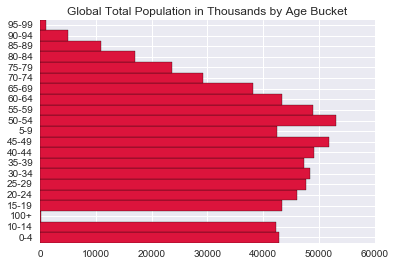

In [17]:
# Total Population in thousands by Age Bucket (country data, not user data)

# Get Total Sum by Age_Bucket
age_pivot = pd.pivot_table(demog, index = 'age_bucket', values = 'population_in_thousands', aggfunc = sum, )
age_pivot = pd.DataFrame(age_pivot)
age_pivot.reset_index(inplace = True)
age_pivot.sort_values(by=['age_bucket'], ascending=[True])

# Plot
action = age_pivot['age_bucket']
count = age_pivot['population_in_thousands']

pos = np.arange(len(action))
width = 1.0

ax = plt.axes()
ax.set_yticks(pos + (width / 2))
ax.set_yticklabels(action)

plt.barh(pos, count, width, color='crimson')
plt.title("Global Total Population in Thousands by Age Bucket")
plt.show()

Age / gender does not seem helpful except to compare total population by age with Airbnb user ages

## Explore countries

In [18]:
# Preview the data

countries.head(20)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [19]:
# Correct punctuation in titles

countries.columns = ['country_destination', 'lat_destination', 'lng_destination', 'distance_km', 'destination_km2', 'destination_language', \
       'language_levenshtein_distance']

In [20]:
# Check unique values

print "Desitination Countries:",countries['country_destination'].unique(),"Count=",len(countries['country_destination'])
print "Languages:",countries['destination_language'].unique(),"Count=",len(countries['destination_language'])

Desitination Countries: ['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NL' 'PT' 'US'] Count= 10
Languages: ['eng' 'deu' 'spa' 'fra' 'ita' 'nld' 'por'] Count= 10


In [21]:
# Delete some columns
del countries['language_levenshtein_distance']
del countries['distance_km']
del countries['destination_km2']

# Delete null values
countries.isnull().sum()

country_destination     0
lat_destination         0
lng_destination         0
destination_language    0
dtype: int64

## Sessions

In [22]:
# Re-import clean data
sessions = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/sessions.csv')

# Establish original count
orig_count = len(sessions)

# Preview the data
sessions.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


In [23]:
# Check unique values

print "# Unique Users:", len(sessions['user_id'].unique())
print "# Unique Actions:", len(sessions['action'].unique())
print "# Unique Action Types", len(sessions['action_type'].unique()), "...", sessions['action_type'].unique()
print "# Unique Action Details", len(sessions['action_detail'].unique())
print "# Unique Device Types", len(sessions['device_type'].unique()), "...", sessions['device_type'].unique()

# Unique Users: 135484
# Unique Actions: 360
# Unique Action Types 11 ... [nan 'click' 'data' 'view' 'submit' 'message_post' '-unknown-'
 'booking_request' 'partner_callback' 'booking_response' 'modify']
# Unique Action Details 156
# Unique Device Types 14 ... ['Windows Desktop' '-unknown-' 'Mac Desktop' 'Android Phone' 'iPhone'
 'iPad Tablet' 'Android App Unknown Phone/Tablet' 'Linux Desktop' 'Tablet'
 'Chromebook' 'Blackberry' 'iPodtouch' 'Windows Phone' 'Opera Phone']


In [24]:
# Check null values

sessions.isnull().sum()

# Oh dear; there are a lot.

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [25]:
# Delete some columns
del sessions['action']
del sessions['action_type']

# Drop all null values from sessions
sessions = sessions.dropna()

In [26]:
# Calculate new vs orignal counts after dropping nulls

new_count = len(sessions)
drop = orig_count-new_count
drop_perc = round(((float(drop))/(float(orig_count))*100))

print "Original Count=",orig_count
print "Count After .dropna()=",new_count
print "Dropped Rows=",drop
print "drop_perc",drop_perc,"%"

Original Count= 10567737
Count After .dropna()= 9277992
Dropped Rows= 1289745
drop_perc 12.0 %


In [27]:
#Simplify Action_details into key words

def reorg_action_detail(list):
    new_col = []
    for i in list: 
        if "host" in i:
            new_col.append('host')
        elif "coupon" in i:
            new_col.append('coupon')
        elif "message" in i:
            new_col.append("message")
        elif "search" in i:
            new_col.append("search")
        elif "profile" in i:
            new_col.append('profile')
        elif "wishlist" in i:
            new_col.append('wishlist')
        elif "review" in i:
            new_col.append('review')
        elif "book" in i:
            new_col.append('book')
        elif "guest" in i: 
            new_col.append("guest")
        elif "cancel" in i or "deactiv" in i:
            new_col.append("cancel")
        else:
            new_col.append("other")

    return new_col

In [28]:
# Insert new column
sessions['action_key_word'] = reorg_action_detail(sessions['action_detail'])

# Delete old column
del sessions['action_detail']

In [29]:
# Preview results

sessions.head()

,user_id,device_type,secs_elapsed,action_key_word
1,d1mm9tcy42,Windows Desktop,67753.0,search
3,d1mm9tcy42,Windows Desktop,22141.0,search
5,d1mm9tcy42,Windows Desktop,7703.0,search
7,d1mm9tcy42,Windows Desktop,831.0,wishlist
8,d1mm9tcy42,Windows Desktop,20842.0,search


In [30]:
# Pivot to find action_key_word median time_elapsed by user_id

sessions_pivot = pd.pivot_table(sessions, index = ['user_id', 'action_key_word','device_type'], aggfunc = np.median)
sessions_pivot.reset_index(inplace=True)
sessions_pivot.columns = ['user_id','action_key_word','device_type','med_secs_elapsed']
sessions_pivot.head()

,user_id,action_key_word,device_type,med_secs_elapsed
0,00023iyk9l,message,Mac Desktop,129817.0
1,00023iyk9l,other,Mac Desktop,811.5
2,00023iyk9l,other,iPhone,2339.5
3,00023iyk9l,search,Mac Desktop,9938.0
4,00023iyk9l,wishlist,Mac Desktop,871.0


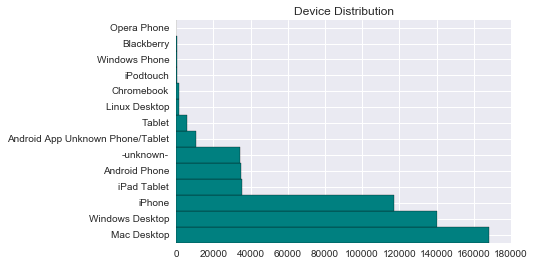

In [31]:
# Device histogram

# Get Values
device_df = pd.DataFrame(sessions_pivot['device_type'].value_counts())
device_df.reset_index(inplace=True)
device_df.columns = ['device','count']

# Plot
device = device_df['device']
count = device_df['count']

pos = np.arange(len(device))
width = 1.0

ax = plt.axes()
ax.set_yticks(pos + (width / 2))
ax.set_yticklabels(device)

plt.barh(pos, count, width, color='teal')
plt.title("Device Distribution")
plt.show()

<img style="float: left;" src="http://imgur.com/TyNLaNH.png">

- Interesting to note that median view length is shorter than median click length
- Views are by far the highest volume activity on Airbnb. People are spending very little time on average viewing properties (scrolling, most likely) but are willing to work through a lot of content.
    - How can Airbnb improve conversion or extend viewing periods?
- Messaging and booking take the longest time to complete on average. Messaging makes sense, but there may be opportunity to expedite the booking process.

## Train_Users

In [32]:
# Re-import clean data
train_users = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/train_users_2.csv')

# Preview data
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [33]:
# Define functions for re-classifying some columns

def reorg_device(list):
    new_col = []
    for i in list:
        if i=='Mac Desktop' or i=='Windows Desktop' or i=='Linux Desktop' or i=='Chromebook':
            new_col.append('Desktop')
        elif i=='iPhone' or i=='Android Phone' or i=='Blackberry' or i=='Opera Phone' or i=='Windows Phone':
            new_col.append('Phone')
        elif i=='iPad Tablet' or i=='Tablet':
            new_col.append('Tablet')
        else:
            new_col.append('Other')
    return new_col

def reorg_OS(list):
    new_col = []
    for i in list:
        if i=='Mac Desktop' or i=='iPhone' or i=='iPad Tablet' or i=='iPodtouch':
            new_col.append('Mac')
        elif i=='Windows Desktop' or i=='Android Phone' or i=='Windows Phone' or i=='Blackberry' or i=='Chromebook'\
            or i=='Android App Unknown Phone/Tablet':
            new_col.append('PC')
        else:
            new_col.append('Other')
    return new_col


def bucket_age(list):
    new_col = []
    for i in list: 
        if i<30:
            new_col.append('18-29')
        elif i>=30 and i<40:
            new_col.append('30-39')
        elif i>=40 and i<65:
            new_col.append('40-64')
        else: 
            new_col.append('>65')
    return new_col

def reorg_gender(list):
    new_col = []
    for i in list: 
        if i=='FEMALE':
            new_col.append('female')
        elif i=='MALE':
            new_col.append('male')
        else:
            new_col.append('other')
    return new_col

In [34]:
# Imputing
median = train_users['age'].median()
train_users['age'].fillna(median, inplace=True)

# Reclassify columns
train_users['first_device_type'] = reorg_device(train_users['first_device_type'])
train_users['first_OS'] = reorg_OS(train_users['first_device_type'])
train_users['age'] = bucket_age(train_users['age'])
train_users['gender'] = reorg_gender(train_users['gender'])

# Delete columns
del train_users['date_first_booking']
# del train_users['signup_method']
# del train_users['signup_flow']
# del train_users['affiliate_channel']
del train_users['first_affiliate_tracked']

In [35]:
# Check if any null values remain

train_users.isnull().sum()

id                        0
date_account_created      0
timestamp_first_active    0
gender                    0
age                       0
signup_method             0
signup_flow               0
language                  0
affiliate_channel         0
affiliate_provider        0
signup_app                0
first_device_type         0
first_browser             0
country_destination       0
first_OS                  0
dtype: int64

In [36]:
# Check results

print "# of rows:", len(train_users)
train_users.head()

# of rows: 213451


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,first_OS
0,gxn3p5htnn,2010-06-28,20090319043255,other,30-39,facebook,0,en,direct,direct,Web,Desktop,Chrome,NDF,Other
1,820tgsjxq7,2011-05-25,20090523174809,male,30-39,facebook,0,en,seo,google,Web,Desktop,Chrome,NDF,Other
2,4ft3gnwmtx,2010-09-28,20090609231247,female,40-64,basic,3,en,direct,direct,Web,Desktop,IE,US,Other
3,bjjt8pjhuk,2011-12-05,20091031060129,female,40-64,facebook,0,en,direct,direct,Web,Desktop,Firefox,other,Other
4,87mebub9p4,2010-09-14,20091208061105,other,40-64,basic,0,en,direct,direct,Web,Desktop,Chrome,US,Other


## Test_Users

In [37]:
# Implement same steps as Train_users

# Re-import clean data
test_users = pd.read_csv('/Users/ebzimm/Desktop/capstone_project/test_users.csv')

# Preview data
test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [38]:
# Imputing
median = test_users['age'].median()
test_users['age'].fillna(median, inplace=True)

# Reclassify columns
test_users['first_device_type'] = reorg_device(test_users['first_device_type'])
test_users['first_OS'] = reorg_OS(test_users['first_device_type'])
test_users['age'] = bucket_age(test_users['age'])
test_users['gender'] = reorg_gender(test_users['gender'])

# Delete columns
del test_users['date_first_booking']
# del test_users['signup_method']
# del test_users['signup_flow']
# del test_users['affiliate_channel']
del test_users['first_affiliate_tracked']

In [39]:
# Check if any null values remain

test_users.isnull().sum()

id                        0
date_account_created      0
timestamp_first_active    0
gender                    0
age                       0
signup_method             0
signup_flow               0
language                  0
affiliate_channel         0
affiliate_provider        0
signup_app                0
first_device_type         0
first_browser             0
first_OS                  0
dtype: int64

In [40]:
# Check results

print "# of rows:",len(test_users)
train_users.head()

# of rows: 62096


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,first_OS
0,gxn3p5htnn,2010-06-28,20090319043255,other,30-39,facebook,0,en,direct,direct,Web,Desktop,Chrome,NDF,Other
1,820tgsjxq7,2011-05-25,20090523174809,male,30-39,facebook,0,en,seo,google,Web,Desktop,Chrome,NDF,Other
2,4ft3gnwmtx,2010-09-28,20090609231247,female,40-64,basic,3,en,direct,direct,Web,Desktop,IE,US,Other
3,bjjt8pjhuk,2011-12-05,20091031060129,female,40-64,facebook,0,en,direct,direct,Web,Desktop,Firefox,other,Other
4,87mebub9p4,2010-09-14,20091208061105,other,40-64,basic,0,en,direct,direct,Web,Desktop,Chrome,US,Other


## Merge Training Data

In [41]:
# Join sessions data with train_users data
train_data = sessions_pivot.set_index('user_id').join(train_users.set_index('id'), how='inner')
train_data.reset_index(inplace=True)

# Reclassify Columns
train_data['device_type'] = reorg_device(train_data['device_type'])
train_data['OS'] = reorg_OS(train_data['device_type'])

# Scale med_time_elapsed data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['med_secs_elapsed'] = scaler.fit_transform(train_data['med_secs_elapsed'])

# Delete columns
del train_data['index']
del train_data['date_account_created']
del train_data['timestamp_first_active']

# Check number of rows
print '# of Rows:', len(train_data)

# Check null values
print pd.DataFrame(train_data.isnull().sum())

/Users/ebzimm/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ebzimm/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


# of Rows: 289023
                     0
action_key_word      0
device_type          0
med_secs_elapsed     0
gender               0
age                  0
signup_method        0
signup_flow          0
language             0
affiliate_channel    0
affiliate_provider   0
signup_app           0
first_device_type    0
first_browser        0
country_destination  0
first_OS             0
OS                   0


In [42]:
# Isolate target
y = train_data['country_destination']

del train_data['country_destination']

In [43]:
# Preview results

train_data.head()

,action_key_word,device_type,med_secs_elapsed,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,first_OS,OS
0,message,Desktop,0.072123,other,30-39,basic,0,en,direct,direct,Web,Desktop,Safari,Other,Other
1,other,Desktop,0.000451,other,30-39,basic,0,en,direct,direct,Web,Desktop,Safari,Other,Other
2,other,Phone,0.001300,other,30-39,basic,0,en,direct,direct,Web,Desktop,Safari,Other,Other
3,search,Desktop,0.005521,other,30-39,basic,0,en,direct,direct,Web,Desktop,Safari,Other,Other
4,wishlist,Desktop,0.000484,other,30-39,basic,0,en,direct,direct,Web,Desktop,Safari,Other,Other


## Merge Testing Data

In [44]:
# Join sessions data with train_users data
test_data = sessions_pivot.set_index('user_id').join(test_users.set_index('id'), how='inner')
test_data.reset_index(inplace=True)

# Reclassify Columns
test_data['device_type'] = reorg_device(test_data['device_type'])
test_data['OS'] = reorg_OS(test_data['device_type'])

# Scale med_time_elapsed data
scaler = MinMaxScaler(feature_range=(0, 1))
test_data['med_secs_elapsed'] = scaler.fit_transform(test_data['med_secs_elapsed'])

# Delete columns
del test_data['index']
del test_data['date_account_created']
del test_data['timestamp_first_active']

# Check number of rows
print '# of Rows:', len(test_data)

# Check null values
print pd.DataFrame(test_data.isnull().sum())

/Users/ebzimm/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ebzimm/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


# of Rows: 261618
                    0
action_key_word     0
device_type         0
med_secs_elapsed    0
gender              0
age                 0
signup_method       0
signup_flow         0
language            0
affiliate_channel   0
affiliate_provider  0
signup_app          0
first_device_type   0
first_browser       0
first_OS            0
OS                  0


## Create Dummy Variables

In [45]:
# Create dummy dfs for train and test data 

def dummies(df):
    return pd.get_dummies(df, columns = \
            ['action_key_word',\
            'device_type',\
            'gender',\
            'age',\
            'signup_flow',\
            'signup_method',\
            'language',\
            'affiliate_channel',\
            'affiliate_provider',\
            'signup_app',\
            'first_device_type',\
            'first_browser',\
            'first_OS',\
            'OS'])

train_dummies = dummies(train_data)
test_dummies = dummies(test_data)

## Model Building

Originally I had factored in the destination country language and distance which were colinear with the target y (destination country). This was yielding very high accuracy scores.

When I realized my mistake and removed the colinear data my scores fell nearly 40% across multiple models.

### Vanilla Logistic Regression

In [46]:
# Check lengths are matching for X and y
print len(y)
print len(train_dummies)

289023
289023


In [47]:
y = y
X = train_dummies
# X_test = test_dummies

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr = LogisticRegression()
model = lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

coef = pd.DataFrame([list(X_train.columns), list(model.coef_[0])], index=['features', 'coef']).T
coef.sort_values(by = 'coef', ascending = False, inplace = True)
coef.reset_index(inplace = True)
del coef['index']
coef

             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       210
         CA       0.00      0.00      0.00       644
         DE       0.00      0.00      0.00       361
         ES       0.00      0.00      0.00      1043
         FR       0.00      0.00      0.00      2031
         GB       0.00      0.00      0.00      1042
         IT       1.00      0.00      0.00      1413
        NDF       0.64      0.87      0.74     53867
         NL       0.00      0.00      0.00       342
         PT       0.00      0.00      0.00       118
         US       0.49      0.37      0.42     29083
      other       0.75      0.00      0.00      5224

avg / total       0.57      0.61      0.55     95378



/Users/ebzimm/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,features,coef
0,language_de,1.09655
1,language_zh,0.615322
2,affiliate_provider_google,0.599375
3,first_browser_Mobile Safari,0.50369
4,affiliate_channel_sem-non-brand,0.477531
5,first_browser_IE,0.385414
6,affiliate_channel_direct,0.344987
7,affiliate_provider_direct,0.344987
8,language_en,0.314007
9,first_browser_Safari,0.299959


### Tree-based Classifiers

In [52]:
dt = DecisionTreeClassifier(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
et = ExtraTreesClassifier(class_weight='balanced')

s = cross_val_score(dt, X, y, n_jobs=-1)
d = cross_val_score(rf, X, y, n_jobs=-1)
f = cross_val_score(et, X, y, n_jobs=-1)

print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", d.mean().round(3), d.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", f.mean().round(3), f.std().round(3)))

Decision Tree Score:	0.481 ± 0.001
Random Forest Score:	0.504 ± 0.001
Extra Trees Score:	0.49 ± 0.001


In [53]:
rf_model = rf.fit(X,y)

In [65]:
coef = pd.DataFrame([list(X_train.columns), list(rf_model.feature_importances_)], index=['features', 'coef']).T
coef['coef'] = pd.to_numeric(coef['coef'])
coef.sort_values(by = 'coef', ascending = False, inplace = True)
coef.reset_index(inplace = True, drop=True)
coef

,features,coef
0,med_secs_elapsed,6.603713e-01
1,age_30-39,1.399591e-02
2,action_key_word_other,1.395281e-02
3,first_browser_Chrome,1.219724e-02
4,first_browser_Safari,1.219580e-02
5,age_40-64,1.123074e-02
6,action_key_word_wishlist,1.105792e-02
7,action_key_word_message,1.104854e-02
8,action_key_word_profile,1.046447e-02
9,action_key_word_search,1.038402e-02


### Logistic Regression with Cross Validation

In [ ]:
# Kernel crashing for all of the below:

In [ ]:
# C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
# penalties = ['l1','l2']

# gs = GridSearchCV(LogisticRegression(solver='liblinear'),
#                  {'C': C_vals,
#                  'penalty': penalties},
#                  cv=10)
# gs.fit(X,y)

In [ ]:
# y_pred = gs.predict(X_test)
# y_score = gs.decision_function(X_test)


# conmat = np.array(confusion_matrix(y, y_pred, labels=[1,0]))
# confusion = pd.DataFrame(conmat, index=['label', 'label'],
#                             columns=['label','label'])

# print(confusion)
# print classification_report(y_test,y_pred2)
# print "roc score:",roc_auc_score(y_test, y_score2)

In [ ]:
# # Plot ROC Curve

# FPR = dict()
# TPR = dict()
# ROC_AUC = dict()

# # For class 1, find the area under the curve
# FPR[1], TPR[1], _ = roc_curve(y_test, y_score2)
# ROC_AUC[1] = auc(FPR[1], TPR[1])

# # Plot of a ROC curve for class 1 (has_cancer)
# plt.figure(figsize=[11,9])
# plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
# plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=18)
# plt.ylabel('True Positive Rate', fontsize=18)
# plt.title('Receiver operating characteristic for high/low income', fontsize=18)
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# coef = pd.DataFrame([list(X.columns), list(gs.best_estimator_.coef_[0])], index=['features', 'coef']).T
# coef.sort_values(by = 'coef', ascending = False, inplace = True)
# coef.reset_index(inplace = True)
# del coef['index']
# coef

### Cluster Analysis

In [67]:
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [68]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_

In [1]:
# Kernel crashing for all of the below

In [ ]:
# silhouette_score(X, labels, metric='euclidean')

In [ ]:
# df['label'] = labels
# df.head()

In [2]:
# fig, ax = plt.subplots(figsize=(10,6))

# plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow');
# ax.set_xticks([]);
# ax.set_yticks([]);

# plt.scatter(centroids[:, 0], centroids[:, 1],
#             marker='x', s=500, linewidths=5,
#             color='k', zorder=10)